Removing the .DS_Store(hidden files) files in the training dataset

In [1]:
import os

dataset_dir = '/Users/js/Desktop/Sign Recognition Application/Sign_to_Sentence Project/Asl_Sign_Data/asl_alphabet_train/asl_alphabet_train'

# Traverse all subdirectories and remove .DS_Store files
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file == ".DS_Store":
            file_path = os.path.join(root, file)
            os.remove(file_path)
            print(f"Removed: {file_path}")

print("All .DS_Store files removed successfully!")


Removed: /Users/js/Desktop/Sign Recognition Application/Sign_to_Sentence Project/Asl_Sign_Data/asl_alphabet_train/asl_alphabet_train/.DS_Store
All .DS_Store files removed successfully!


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2


Data Visualisation

Classes: ['R', 'U', 'I', 'N', 'G', 'Z', 'T', 'S', 'A', 'F', 'O', 'H', 'del', 'nothing', 'space', 'M', 'J', 'C', 'D', 'V', 'Q', 'X', 'E', 'B', 'K', 'L', 'Y', 'P', 'W']


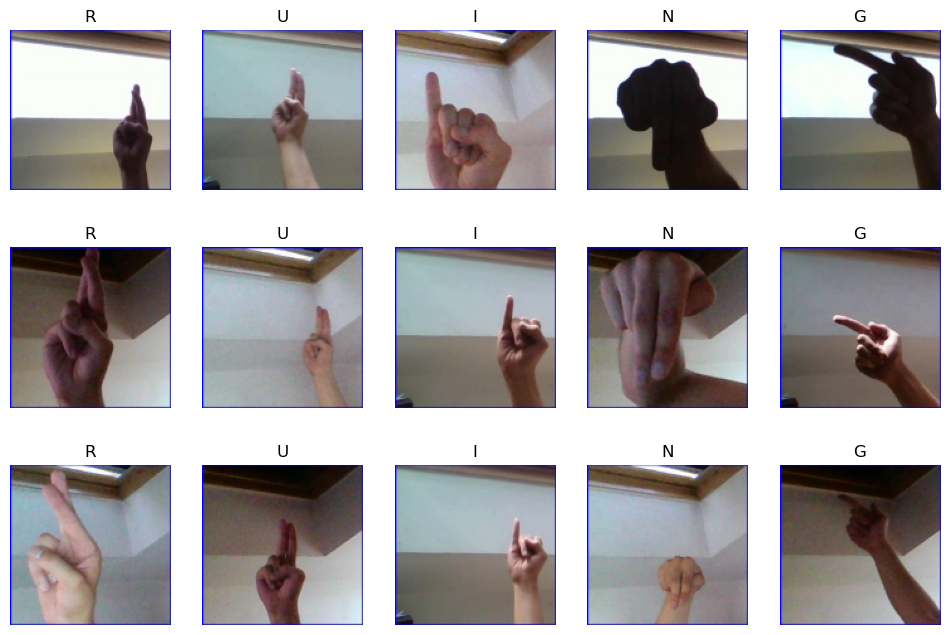

In [3]:
dataset_dir = '/Users/js/Desktop/Sign Recognition Application/Sign_to_Sentence Project/Asl_Sign_Data/asl_alphabet_train/asl_alphabet_train'

classes = os.listdir(dataset_dir)
print(f"Classes: {classes}")

# Visualize some images
fig, axes = plt.subplots(3, 5, figsize=(12, 8))

for i, label in enumerate(classes[:5]):  # Show first 5 classes
    class_dir = os.path.join(dataset_dir, label)
    img_files = os.listdir(class_dir)[:3]  # Show 3 images per class

    for j, img_name in enumerate(img_files):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, (128, 128))
        
        axes[j, i].imshow(img)
        axes[j, i].axis("off")
        axes[j, i].set_title(label)

plt.show()

Data Pre-processing

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
IMG_SIZE = 128 
BATCH_SIZE = 32

# Data generators
# We are using this approach to make it less computaionally extensive as the data consists of 87,000 images appx,
# loading all the images as generally done and then label encoding them will be CPU extensive task. 

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Splitting data into train (80%) and val (20%)
)

# Train & validation generators (load images directly from disk)
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

print("Class labels:", train_generator.class_indices)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
Class labels: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


Defining the MobileNet V2 Model

In [5]:
base_model = MobileNetV2(
    weights="imagenet", 
    include_top=False, 
    input_shape=(128, 128, 3)
)

base_model.trainable = False  # Freezing all layers initially as this is an intial training

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
output_layer = Dense(len(train_generator.class_indices), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

2025-02-13 01:57:16.054731: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-02-13 01:57:16.054769: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-13 01:57:16.054773: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-02-13 01:57:16.054854: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-13 01:57:16.055057: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Initial training on the dataset

In [6]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5 
)

Epoch 1/5


2025-02-13 01:57:59.913467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2175/2175 [==============================] - ETA: 0s - loss: 1.0828 - accuracy: 0.6956

2025-02-13 02:00:56.117757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2175/2175 [==============================] - 219s 100ms/step - loss: 1.0828 - accuracy: 0.6956 - val_loss: 1.2434 - val_accuracy: 0.6503
Epoch 2/5
2175/2175 [==============================] - 215s 99ms/step - loss: 0.7118 - accuracy: 0.7996 - val_loss: 1.2324 - val_accuracy: 0.6818
Epoch 3/5
2175/2175 [==============================] - 212s 98ms/step - loss: 0.7056 - accuracy: 0.8108 - val_loss: 1.5563 - val_accuracy: 0.6512
Epoch 4/5
2175/2175 [==============================] - 212s 97ms/step - loss: 0.7269 - accuracy: 0.8175 - val_loss: 1.3931 - val_accuracy: 0.6907
Epoch 5/5
2175/2175 [==============================] - 209s 96ms/step - loss: 0.7342 - accuracy: 0.8200 - val_loss: 1.4348 - val_accuracy: 0.6878


Fine Tuning the model further

In [7]:
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

# Recompile with a lower learning rate to avoid overfitting
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Epoch 1/10


2025-02-13 02:16:02.994529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2175/2175 [==============================] - ETA: 0s - loss: 0.7921 - accuracy: 0.8398

2025-02-13 02:18:55.614769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2175/2175 [==============================] - 216s 98ms/step - loss: 0.7921 - accuracy: 0.8398 - val_loss: 1.7578 - val_accuracy: 0.7355
Epoch 2/10
2175/2175 [==============================] - 214s 99ms/step - loss: 0.4409 - accuracy: 0.9029 - val_loss: 1.4791 - val_accuracy: 0.7784
Epoch 3/10
2175/2175 [==============================] - 215s 99ms/step - loss: 0.3620 - accuracy: 0.9185 - val_loss: 1.3450 - val_accuracy: 0.7795
Epoch 4/10
2175/2175 [==============================] - 221s 101ms/step - loss: 0.2976 - accuracy: 0.9312 - val_loss: 1.3633 - val_accuracy: 0.7893
Epoch 5/10
2175/2175 [==============================] - 210s 97ms/step - loss: 0.2630 - accuracy: 0.9389 - val_loss: 1.2381 - val_accuracy: 0.8111
Epoch 6/10
2175/2175 [==============================] - 209s 96ms/step - loss: 0.2293 - accuracy: 0.9450 - val_loss: 1.3404 - val_accuracy: 0.8011
Epoch 7/10
2175/2175 [==============================] - 212s 98ms/step - loss: 0.2064 - accuracy: 0.9500 - val_loss: 1.4876 - va

In [8]:
model.save("sign_language_model_MobileNetV2.h5")
print("Model saved successfully!")

/Users/js/tensorflow-test/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully!


Model Testing

In [9]:
# Load the trained model
model = tf.keras.models.load_model("sign_language_model_MobileNetV2.h5")

print("Model loaded successfully!")

Model loaded successfully!


In [10]:
class_labels = {
    0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G", 7: "H",
    8: "I", 9: "J", 10: "K", 11: "L", 12: "M", 13: "N", 14: "O",
    15: "P", 16: "Q", 17: "R", 18: "S", 19: "T", 20: "U", 21: "V",
    22: "W", 23: "X", 24: "Y", 25: "Z", 26: "del", 27: "nothing", 28: "space"
}


In [11]:
IMG_SIZE = 128 
test_folder = '/Users/js/Desktop/Sign Recognition Application/Sign_to_Sentence Project/Asl_Sign_Data/asl_alphabet_test/asl_alphabet_test'
test_images = []
image_names = []

for img_name in os.listdir(test_folder):
    if img_name.endswith((".jpg", ".png", ".jpeg")):
        img_path = os.path.join(test_folder, img_name)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        test_images.append(img)
        image_names.append(img_name)

# Convert to NumPy array
test_images = np.array(test_images)

print(f"Loaded {len(test_images)} test images.")


Loaded 28 test images.


In [12]:
# Get model predictions
predictions = model.predict(test_images)

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

for i, img_name in enumerate(image_names):
    pred_label = class_labels[predicted_classes[i]]
    print(f"Image: {img_name} → Predicted as: {pred_label}")


2025-02-13 02:54:24.658219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 738ms/step
Image: F_test.jpg → Predicted as: F
Image: G_test.jpg → Predicted as: G
Image: L_test.jpg → Predicted as: L
Image: M_test.jpg → Predicted as: M
Image: R_test.jpg → Predicted as: R
Image: S_test.jpg → Predicted as: S
Image: X_test.jpg → Predicted as: X
Image: Y_test.jpg → Predicted as: Y
Image: U_test.jpg → Predicted as: U
Image: T_test.jpg → Predicted as: T
Image: A_test.jpg → Predicted as: A
Image: K_test.jpg → Predicted as: K
Image: J_test.jpg → Predicted as: J
Image: Z_test.jpg → Predicted as: Z
Image: nothing_test.jpg → Predicted as: nothing
Image: Q_test.jpg → Predicted as: Q
Image: P_test.jpg → Predicted as: P
Image: space_test.jpg → Predicted as: space
Image: O_test.jpg → Predicted as: O
Image: N_test.jpg → Predicted as: N
Image: E_test.jpg → Predicted as: E
Image: D_test.jpg → Predicted as: D
Image: H_test.jpg → Predicted as: H
Image: I_test.jpg → Predicted as: I
Image: B_test.jpg → Predicted as: B
Image: C_test.jpg → Predict

Test Accuracy

In [13]:
true_labels = [img_name.split("_")[0] for img_name in image_names]

correct = sum([1 if class_labels[predicted_classes[i]] == true_labels[i] else 0 for i in range(len(true_labels))])
accuracy = correct / len(true_labels) * 100

print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 100.00%


Results Visualisation

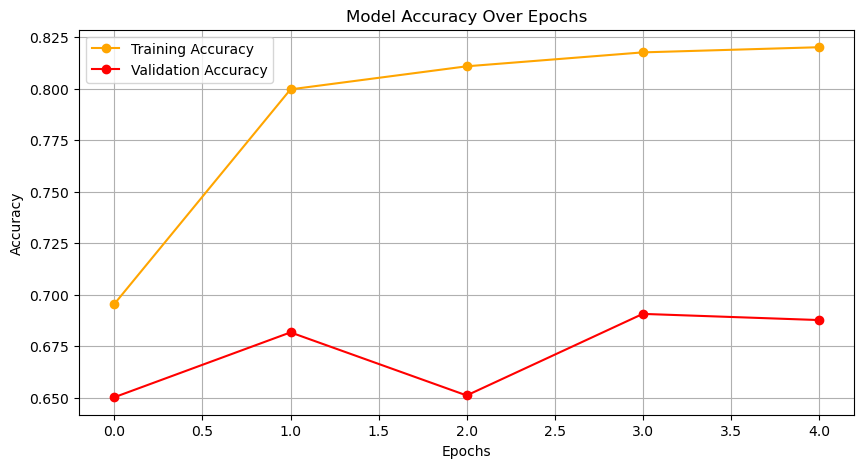

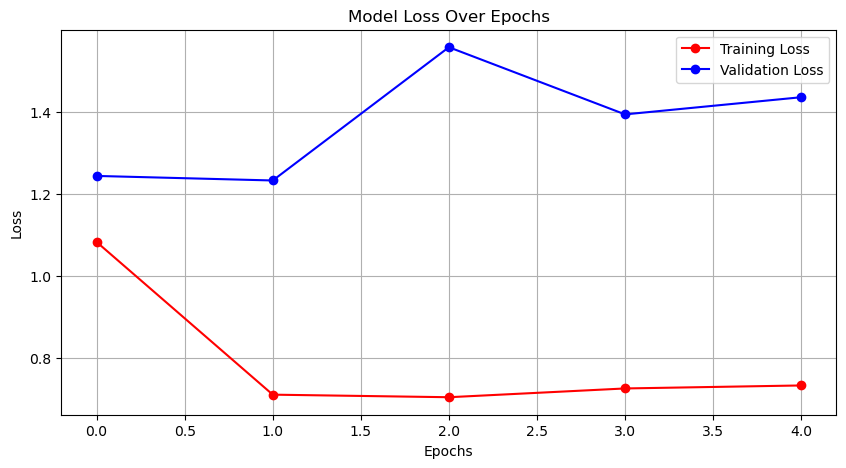

In [14]:
history_dict = history.history

# Plot Accuracy Graph
plt.figure(figsize=(10, 5))
plt.plot(history_dict["accuracy"], label="Training Accuracy", marker="o", color="orange")
plt.plot(history_dict["val_accuracy"], label="Validation Accuracy", marker="o", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss Graph
plt.figure(figsize=(10, 5))
plt.plot(history_dict["loss"], label="Training Loss", marker="o", color="red")
plt.plot(history_dict["val_loss"], label="Validation Loss", marker="o", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


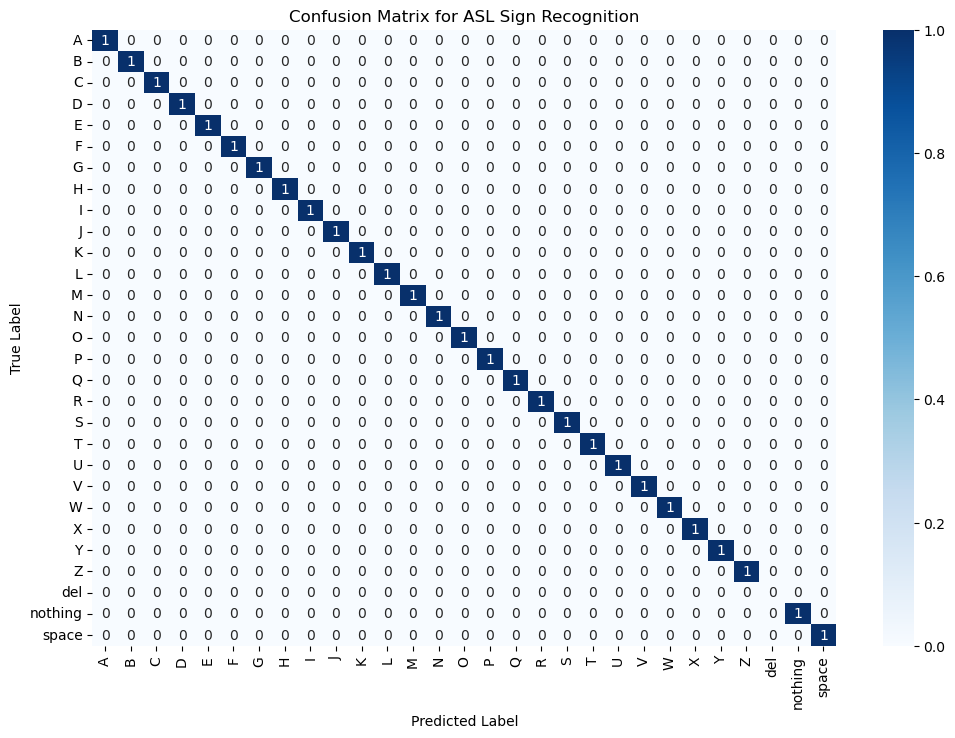

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, [class_labels[i] for i in predicted_classes], labels=list(class_labels.values()))

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for ASL Sign Recognition")
plt.show()

Predicting the Signs from camera feed

- The approach is to use mediapipe to find the center of the hand, make a box/ frame around it, pass the image inside of frame to the trained model.

- Since MobileNet V2 is convolutional neural network, it would not give accurate results on real life data

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf

# Load trained MobileNetV2 model
mobilenet_model = tf.keras.models.load_model("sign_language_model_MobileNetV2.h5")

# Correct class labels (matching `train_generator.class_indices`)
class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
                'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
                'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.7)

cap = cv2.VideoCapture(0)

#Bounding Box Adjustments
HEIGHT_EXPAND = 220
WIDTH_EXPAND = 150

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_frame)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Get bounding box coordinates
            x_min = min([lm.x for lm in hand_landmarks.landmark]) * frame.shape[1]
            y_min = min([lm.y for lm in hand_landmarks.landmark]) * frame.shape[0]
            x_max = max([lm.x for lm in hand_landmarks.landmark]) * frame.shape[1]
            y_max = max([lm.y for lm in hand_landmarks.landmark]) * frame.shape[0]

            x_min = max(0, int(x_min - WIDTH_EXPAND))   
            y_min = max(0, int(y_min - HEIGHT_EXPAND)) 
            x_max = min(frame.shape[1], int(x_max + WIDTH_EXPAND))  
            y_max = min(frame.shape[0], int(y_max + HEIGHT_EXPAND)) 

            # Crop the hand region
            hand_crop = frame[y_min:y_max, x_min:x_max]

            # Resize to (128x128) for MobileNetV2
            if hand_crop.shape[0] > 0 and hand_crop.shape[1] > 0:
                hand_resized = cv2.resize(hand_crop, (128, 128))
                hand_resized = np.expand_dims(hand_resized, axis=0) / 255.0  # Normalize

                # Predict using MobileNetV2
                prediction = mobilenet_model.predict(hand_resized)
                
                # Get top 3 predictions
                top_3_indices = np.argsort(prediction[0])[-3:][::-1]
                top_3_labels = [class_labels[i] for i in top_3_indices]
                top_3_scores = [prediction[0][i] for i in top_3_indices]

                # Debugging: Print top 3 predictions
                print(f"Top 3 Predictions: {list(zip(top_3_labels, top_3_scores))}")

                # Get the best prediction
                predicted_label = top_3_labels[0]

                # Display Prediction
                cv2.putText(frame, f"Predicted: {predicted_label}", (50, 50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    cv2.imshow("MobileNetV2 Sign Prediction (Fixed Bounding Box Height)", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


I0000 00:00:1739396069.341868       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
2025-02-13 03:04:33.504240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 625ms/step
Top 3 Predictions: [('N', 0.44184786), ('T', 0.2772988), ('A', 0.27032706)]
1/1 [==============================] - 0s 21ms/step
Top 3 Predictions: [('A', 1.0), ('N', 7.2662143e-09), ('M', 3.690396e-09)]
1/1 [==============================] - 0s 40ms/step
Top 3 Predictions: [('A', 0.99998856), ('E', 5.5430037e-06), ('Y', 4.4389762e-06)]
1/1 [==============================] - 0s 20ms/step
Top 3 Predictions: [('A', 0.9999982), ('N', 1.5249442e-06), ('M', 2.5560072e-07)]
1/1 [==============================] - 0s 20ms/step
Top 3 Predictions: [('A', 0.9999987), ('J', 1.3560089e-06), ('E', 3.278712e-08)]
1/1 [==============================] - 0s 20ms/step
Top 3 Predictions: [('A', 0.9999862), ('J', 1.382331e-05), ('E', 1.0347119e-09)]
1/1 [==============================] - 0s 20ms/step
Top 3 Predictions: [('A', 0.9999968), ('J', 3.0186106e-06), ('N', 2.3966592e-07)]
1/1 [==============================] - 0s 20ms/step
Top 3 Predictions: [('A

2025-02-13 03:04:42.720 python[84888:5344554] _TIPropertyValueIsValid called with 16 on nil context!
2025-02-13 03:04:42.720 python[84888:5344554] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-02-13 03:04:42.720 python[84888:5344554] Text input context does not respond to _valueForTIProperty:


KeyboardInterrupt: 

: 

After testing it is seen that this model is useful and clasifies the signs correctly which has distinct unique shapes like - letter A, L, etc but fails in complex signs like - letter K, X etc.